In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet152, ResNet152_Weights
from sklearn.model_selection import train_test_split
import torch.optim as optim
from image_transforms import standard_transform
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime
from trainer import train
import json
import cv2
from image_transforms import OuterEdgeCrop

In [2]:
#store current time
date_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

In [3]:
#import resnet
resnet_model = resnet152()


In [4]:
from PIL import Image
#load data
dataset_path = 'datasets/2023-12-08-16-54'
dataset = ImageFolder(root=dataset_path, transform=standard_transform())
edge_cropper = OuterEdgeCrop()
#filter the dataset

image_crop = edge_cropper.find_outer_edges(Image.open('datasets/2023-12-08-16-54/Age-related Macular Degeneration/ODIR-5k_Training Images_1064_right.jpg'))
print(image_crop)

# for image, label in dataset:
#     i = 0
#     print('image', type(image))
#     print(i, image.shape)
#     i += 1
#     image_crop = edge_cropper.find_outer_edges(image)
#     if image_crop is None:
#         #print path
#         print(dataset.samples[i][0])
#         #print image name
#         #remove image from dataset
#         #dataset.samples.remove((image,label))
targets = dataset.targets
#split data into train, test, val
#70-20-10
train_val_idx, test_idx= train_test_split(np.arange(len(targets)),test_size=0.2,shuffle=True,stratify=targets, random_state=42)
print(type(train_val_idx))
train_val_idx_list = train_val_idx.tolist()
train_val_stratifier = np.take(targets,train_val_idx_list)
#targets[train_val_idx_list]
train_idx, validation_idx = train_test_split(train_val_idx,test_size=0.125,shuffle=True,stratify=train_val_stratifier, random_state=42)
#adjust classifier to match number of classes +1 for uncertain
resnet_model.fc = nn.Linear(2048, len(dataset.classes))
#load data into dataloader
batch_size = 64

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
validation_sampler = torch.utils.data.SubsetRandomSampler(validation_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=validation_sampler)

(1555, 1555)
<class 'numpy.ndarray'>


In [5]:
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
print("Number of train samples: ", len(train_idx), (len(train_loader.sampler)))

Number of train samples:  2134 2134


In [7]:
def plot_data_loader_class_distribution(loader: DataLoader, title : str):
    #plot class distribution in dataset
    class_counts = {class_idx: 0 for class_idx in range(len(dataset.classes))}

    # Count the number of samples in each class in train dataloader
    for _, label in train_loader:
        for class_idx in label:
            print(class_idx.item())
            class_counts[class_idx.item()] += 1
    # Plot the distribution
    classes = [dataset.classes[idx] for idx in class_counts.keys()]
    counts = [class_counts[idx] for idx in class_counts.keys()]

    plot = plt.bar(classes, counts)
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
    return plot

In [8]:
if False:
    plot_data_loader_class_distribution(train_loader, 'Train Data Class Distribution')
    plt.savefig(f'dataset_plots/{date_time}/train_data.png')
    plt.show()
    plot_data_loader_class_distribution(validation_loader, 'Validation Data Class Distribution')
    plt.savefig(f'dataset_plots/{date_time}/validation_data.png')
    plt.show()
    plot_data_loader_class_distribution(test_loader, 'Test Data Class Distribution')
    plt.savefig(f'dataset_plots/{date_time}/test_data.png')
    plt.show()

(2304, 3456, 3)


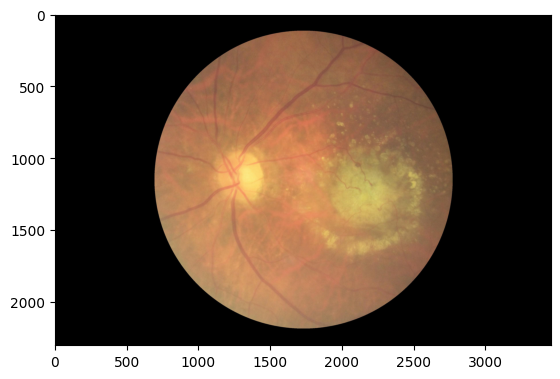

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
#plot one example with and without the transform
#pathn to example image
path = 'datasets/2023-12-07-12-57/age-related macular degeneration/43_left.jpg'
img = cv2.imread(path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img_rgb.shape)
#show image
plt.imshow(img_rgb)
plt.show()
#transform image to tensor
pil_img = Image.open(path).convert('RGB')
pil_img = standard_transform()(pil_img)
#show image
pil_img = transforms.ToPILImage()(pil_img)
pil_img.show()

In [ ]:
print(len(dataset.classes))

In [10]:
model = resnet_model
n_classes = len(dataset.classes) #+ 1
batch_size = 64
epochs = 50
lr = 0.001
dataset_path = dataset_path
best_weights_save_path = f'models/{date_time}_{resnet_model.__class__.__name__}.pth'
train_loader = train_loader
validation_loader = validation_loader

#train model
model_history_dict = train(model=resnet_model, n_classes=n_classes, train_loader=train_loader, batch_size=10, lr=0.001, dataset_path="dummy_path", best_weights_save_path="dummy_path",
                                epochs=30, validation_loader=validation_loader, n_epochs_validation=1, early_stopping=True, patience=5,
                                  wandb_project_name="dummy_project", wandb_run_name="dummy_run_res", wandb_tags=["dummy_tag"], wandb_api_key='28206af99a544e605ea5edf81110c79035d408bc', prefered_device='cuda')
print(model_history_dict)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\elyes/.netrc
wandb: Currently logged in as: elyes-farjallah (inherited-retinal-disease). Use `wandb login --relogin` to force relogin


Epochs: 100%|██████████| 30/30 [1:24:51<00:00, 169.73s/it, validation loss=1.43, validation accuracy=0.439]


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch,29


{'train': {'accuracy': [0.3050609230995178, 0.1855670064687729, 0.2221180945634842, 0.24742268025875092, 0.27460169792175293, 0.276476114988327, 0.29428303241729736, 0.3045923113822937, 0.3355201482772827, 0.342549204826355, 0.3523898720741272, 0.3528584837913513, 0.3683224022388458, 0.3673851788043976, 0.3776944577693939, 0.3987816274166107, 0.41096532344818115, 0.3903467655181885, 0.41518276929855347, 0.44376757740974426, 0.442830353975296, 0.40909090638160706, 0.4465791881084442, 0.4657919406890869, 0.47188377380371094, 0.467666357755661, 0.4925023317337036, 0.47610121965408325, 0.5070290565490723, 0.5182755589485168], 'precision_micro': [0.3050609230995178, 0.1855670064687729, 0.2221180945634842, 0.24742268025875092, 0.27460169792175293, 0.276476114988327, 0.29428303241729736, 0.3045923113822937, 0.3355201482772827, 0.342549204826355, 0.3523898720741272, 0.3528584837913513, 0.3683224022388458, 0.3673851788043976, 0.3776944577693939, 0.3987816274166107, 0.41096532344818115, 0.390346

In [ ]:
#show third image in train loader
from image_transforms import OuterEdgeCrop
cropper = OuterEdgeCrop()
for images, labels in train_loader:
    crops = cropper(images)

In [ ]:
#save model history dict to json file
with open(f'{best_weights_save_path}.json', 'w') as fp:
    json.dump(model_history_dict, fp)

In [ ]:
best_val_accuracy = max(model_history_dict['validation']['accuracy'])
print(f'Best validation accuracy: {best_val_accuracy}', 'n_classes', n_classes)